In [1]:
# magic lines that avoid re-start 

import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

## Global setting: change with PC or HPC
# Path_NiallDMA = "InputData/" # for HPC
Path_NiallDMA = "D:/OneDrive - Imperial College London/SimDataSave/InputData/"
# BasicPath=os.getcwd() # for HPC
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2_R9_Dim/Test' 
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC


In [ ]:
# debug dry-out rate:
def Dryout_Rate(VmolEC):
    #VmolEC    = 6.667e-05
    VmolSEI   = 9.585e-05
    VmolLiP   = 1.3e-05
    # for 1 mol LLI to SEI or something else:
    LLINegSEI = 1; LLINegSEIcr = 1; LLINegDeadLiP = 0; LLINegLiP  = 0

    Vol_EC_consumed  =  ( LLINegSEI + LLINegSEIcr + LLINegDeadLiP  ) * 2 * VmolEC    
    # Mark: Ruihe add LLINegDeadLiP, either with 2 or not, 
    # will decide how fast electrolyte being consumed!

    Vol_SEILiP_increase = 1.0*(
        (LLINegSEI+LLINegSEIcr) * VmolSEI 
        + LLINegLiP * VmolLiP)    #  volume increase due to SEI+total LiP 
    # Test_V = Vol_SEILiP_increase - Vol_Pore_decrease 
    Vol_Elely_need   = Vol_EC_consumed - Vol_SEILiP_increase
    #print(VmolEC,Vol_Elely_need)
    # assumem 0.25Ah capacity loss, total pore volume is ~5mL
    vol_pore_tot = 5 # mL
    consum_percen = 0.25*1/26.801* (Vol_Elely_need*1E6) /2/vol_pore_tot*100
    return Vol_Elely_need,consum_percen
fs=14;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Vol_Elely_need_all = []; Consum_p = []
VmolEC = np.arange(4.7925e-5,8e-05,5e-6)
for VmolEC_i in VmolEC:
    Vol_Elely_need_i,consum_percen = Dryout_Rate(VmolEC_i)
    Vol_Elely_need_all.append(Vol_Elely_need_i)
    Consum_p.append(consum_percen)
fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
ax.plot(VmolEC,Consum_p,"-o")
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.set_xlabel('EC partial molar volume [m3.mol-1]')
ax.set_ylabel('Elely need / tot pore %')

In [ ]:
# Set Experiment : Exp-2
index_exp = 3 # index for experiment set, can now go for 2,3,5
Round_No = "DryoutRate"  # index to identify different rounds of running 
pool_no = 2

if index_exp == 2:
    tot_cyc = 6192; cyc_age = 516;
if index_exp == 3:
    tot_cyc = 3; cyc_age = 1;
if index_exp == 5:
    tot_cyc = 1170; cyc_age = 78;

#########  Actively sweep parameters  ##############
Para_active = {
   "Ageing temperature":[25,], # 25, 40 
   "Total ageing cycles":[int(tot_cyc),], # 
   "Ageing cycles between RPT":[int(cyc_age),], # 
   "Update cycles for ageing": [int(cyc_age),],
   "Initial electrolyte excessive amount ratio":[ 1.5], # set to <1 for DryOut=Off
   # rate of dry-out:
   "EC partial molar volume [m3.mol-1]":[6.667e-06,6.667e-05,6.667e-04,] ,
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-18,],    
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 1e-8,], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 1e-6,], # default: 2.7778e-07
   "Negative electrode cracking rate":[ 1e-20,],   # default: function, ~3.9e-20 
}


In [2]:
# Inactively sweep parameters
Para_dict_Same = {
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20 
   "Cycles within RPT":[1,],
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
         "contact resistance": "true",
         "open-circuit potential": "current sigmoid",
         "thermal": "lumped",
         "SEI": "interstitial-diffusion limited",
         "SEI on cracks": "true",
         "SEI film resistance": "distributed", 
         "SEI porosity change": "true",
         "particle mechanics": ("swelling and cracking", "swelling only"),
         "loss of active material": "stress-driven",
         "lithium plating": "partially reversible",
      },
      ],
   "Contact resistance [Ohm]": [0.0105,],   
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   
   #"Negative electrode volume change":[ 0.0,],
   #"Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),
}
Para_dict_All = {**Para_dict_Same,**Para_active}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")


Total scan case is 3


In [3]:
# set up experiment
Target  = f'/Exp{index_exp}_Round_{Round_No}/'
book_name_xlsx = f'Exp{index_exp}_Round_{Round_No}.xlsx';
V_max = 4.2;        V_min = 2.5; 
if index_exp ==2:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
        ),  ]  # *  setting on cycler is 516, rather than 514 in wiki
elif index_exp ==3:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]   # *  setting on cycler is 515, rather than 514 in wiki
elif index_exp ==5:
    exp_AGE_text = [(
        f"Discharge at 1C until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]  # *  78
else:
    print("Not yet implemented!")
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

# remaining set-up for experiment and create folders
sheet_name_xlsx = 'Results';
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
if not os.path.exists(BasicPath + Target+"Mats"):
   os.mkdir(BasicPath + Target+"Mats");
if not os.path.exists(BasicPath + Target+"Plots"):
   os.mkdir(BasicPath + Target+"Plots");
if not os.path.exists(BasicPath + Target+"Excel"):
   os.mkdir(BasicPath + Target+"Excel");

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,]

exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

exp_text_list = [exp_AGE_text,  exp_RPT_text ];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_0p1C_CD, step_0p1C_CC,step_0p1C_RE , step_0p5C_CD ];



In [4]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]

# Load Niall's data
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


In [5]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [6]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %","Dry out"]

head_pos = [ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values_para = []
    for value_list_temp_i in value_list_temp:
        values_para.append(str(value_list_temp_i))
    # sequence: scan no, exp, pass or fail, mpe, dry-out, 
    mpe_all = ["Unknown","Unknown",
        "Unknown","Unknown", 
        "Unknown","Unknown",]
    Pass_Fail = "Unknown"
    DryOut = "Unknown"
    value_Pre = [str(Scan_i),index_exp,Pass_Fail,*mpe_all,DryOut,]
    values = [*value_Pre,*values_para,]
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   


Successfully create a excel file


Start Now! Scan 1.
Scan 1: DryOut = On
Initial electrolyte amount is  7.564574442461399 mL
Scan 1: Spent 6.733 ms on Initialization


At t = 1270.05 and h = 7.67719e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish break-in cycle within 1 minute, 29 seconds
Scan 1: Finish post-process for break-in cycle within 177.459 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)
Scan 1: Finish for No.0 ageing cycles within 10.542 s
Scan 1: Finish post-process for No.1 ageing cycles within 84.932 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)


At t = 1155.64 and h = 2.56384e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 353.945 and h = 1.40012e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1 RPT cycles within 1 minute, 30 seconds
Scan 1: Finish post-process for No.1 RPT cycles within 121.613 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)
Scan 1: Finish for No.1 ageing cycles within 9.844 s
Scan 1: Finish post-process for No.2 ageing cycles within 57.063 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)


At t = 1098.51 and h = 3.45773e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 343.584 and h = 1.15759e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.2 RPT cycles within 1 minute, 29 seconds
Scan 1: Finish post-process for No.2 RPT cycles within 123.353 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)
Scan 1: Finish for No.2 ageing cycles within 9.878 s
Scan 1: Finish post-process for No.3 ageing cycles within 53.009 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)


At t = 1050.9 and h = 1.3589e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 334.645 and h = 9.33528e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.3 RPT cycles within 1 minute, 30 seconds
Scan 1: Finish post-process for No.3 RPT cycles within 128.001 ms
Scan 1: Getting extra variables within 67.100 us
Scan 1: Finish all plots within 5.016 s
Successfully create a excel file
Scan 1: Finish saving mat and xlsx within 20.873 ms
Succeed doing something in 6 minutes, 34 seconds
This is the end of No. 1  scan
Start Now! Scan 2.
Scan 2: DryOut = On
Initial electrolyte amount is  7.564574442461399 mL
Scan 2: Spent 452.400 us on Initialization


At t = 1270.07 and h = 3.57052e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish break-in cycle within 1 minute, 27 seconds
Scan 2: Finish post-process for break-in cycle within 176.570 ms
Scan 2: Finish for No.0 ageing cycles within 10.866 s
Scan 2: Finish post-process for No.1 ageing cycles within 80.978 ms


At t = 1155.6 and h = 2.51426e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 353.904 and h = 1.07907e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.1 RPT cycles within 1 minute, 38 seconds
Scan 2: Finish post-process for No.1 RPT cycles within 126.170 ms
Scan 2: Finish for No.1 ageing cycles within 10.069 s
Scan 2: Finish post-process for No.2 ageing cycles within 63.065 ms


At t = 1098.41 and h = 8.6068e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 343.517 and h = 1.40003e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.2 RPT cycles within 1 minute, 32 seconds
Scan 2: Finish post-process for No.2 RPT cycles within 127.618 ms
Scan 2: Finish for No.2 ageing cycles within 10.674 s
Scan 2: Finish post-process for No.3 ageing cycles within 50.910 ms


At t = 1050.71 and h = 5.57855e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 334.553 and h = 1.15001e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.3 RPT cycles within 1 minute, 30 seconds
Scan 2: Finish post-process for No.3 RPT cycles within 122.149 ms
Scan 2: Getting extra variables within 79.700 us
Scan 2: Finish all plots within 4.900 s
Successfully create a excel file
Scan 2: Finish saving mat and xlsx within 21.529 ms
Succeed doing something in 6 minutes, 44 seconds
This is the end of No. 2  scan
Start Now! Scan 3.
Scan 3: DryOut = On
Initial electrolyte amount is  7.564574442461399 mL
Scan 3: Spent 610.200 us on Initialization


At t = 1270.07 and h = 7.94816e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish break-in cycle within 1 minute, 32 seconds
Scan 3: Finish post-process for break-in cycle within 227.982 ms
Scan 3: Finish for No.0 ageing cycles within 10.557 s
Scan 3: Finish post-process for No.1 ageing cycles within 75.656 ms


At t = 1154.79 and h = 4.27712e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 353.313 and h = 5.41789e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1 RPT cycles within 1 minute, 34 seconds
Scan 3: Finish post-process for No.1 RPT cycles within 134.975 ms
Scan 3: Finish for No.1 ageing cycles within 11.229 s
Scan 3: Finish post-process for No.2 ageing cycles within 65.685 ms


At t = 1096.42 and h = 6.49069e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 342.594 and h = 2.34969e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.2 RPT cycles within 1 minute, 34 seconds
Scan 3: Finish post-process for No.2 RPT cycles within 129.750 ms
Scan 3: Finish for No.2 ageing cycles within 13.201 s
Scan 3: Finish post-process for No.3 ageing cycles within 55.365 ms


At t = 1047.43 and h = 1.01739e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 333.3 and h = 8.87692e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.3 RPT cycles within 1 minute, 37 seconds
Scan 3: Finish post-process for No.3 RPT cycles within 119.698 ms
Scan 3: Getting extra variables within 63.900 us
Scan 3: Finish all plots within 4.858 s
Successfully create a excel file
Scan 3: Finish saving mat and xlsx within 21.184 ms
Succeed doing something in 6 minutes, 58 seconds
This is the end of No. 3  scan


' for result in Result:\n    midc_merge_all.append(result[0])\n    Sol_RPT_all.append(result[1])\n    Sol_AGE_all.append(result[2])  '

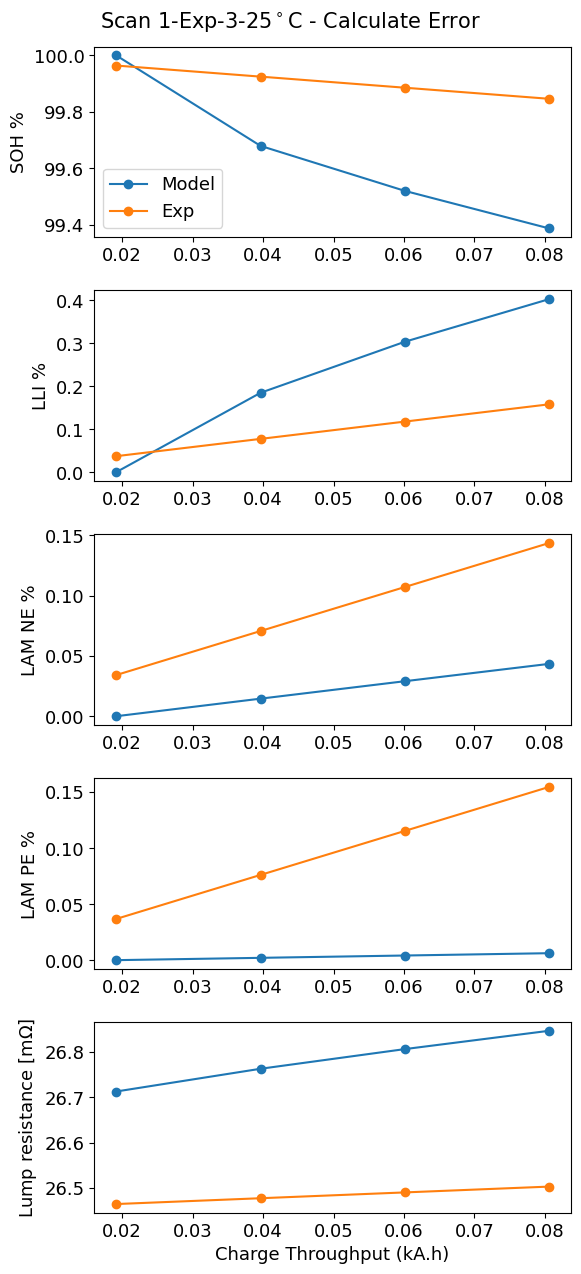

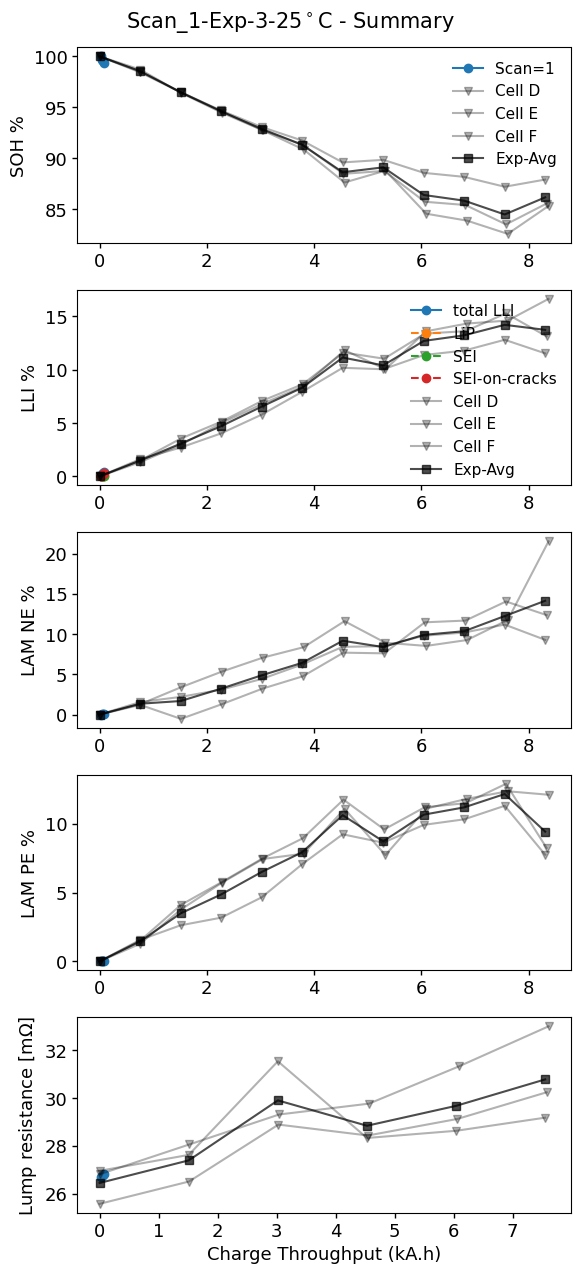

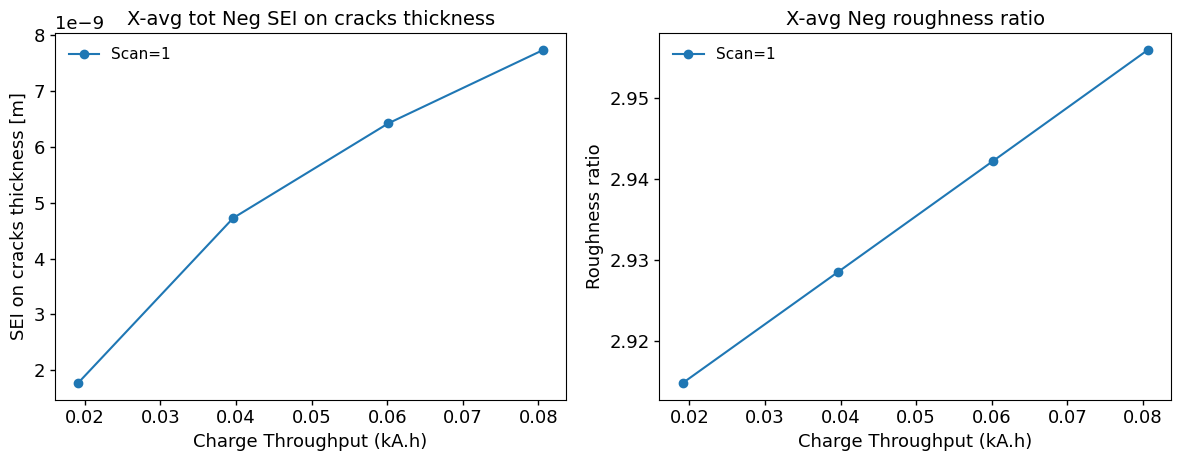

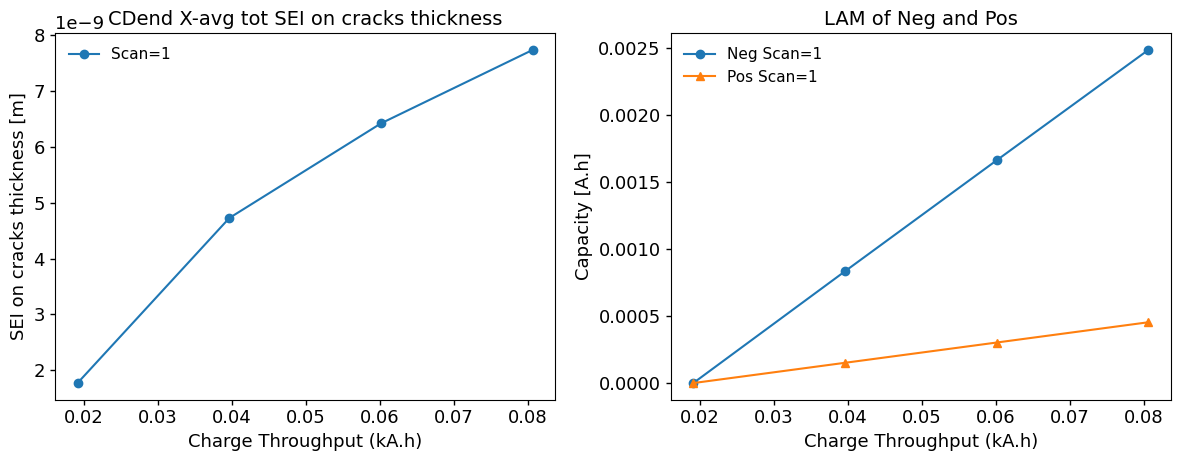

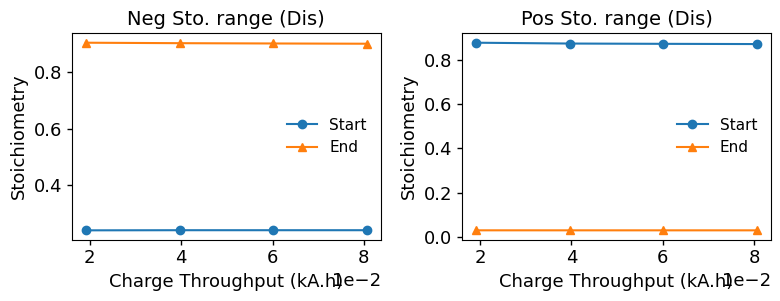

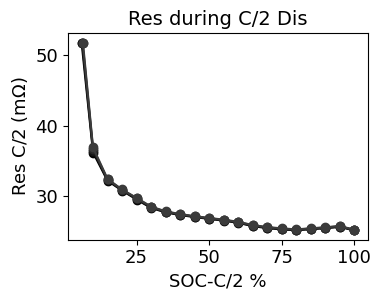

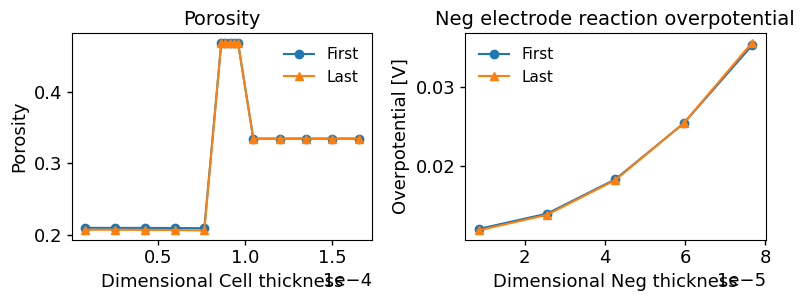

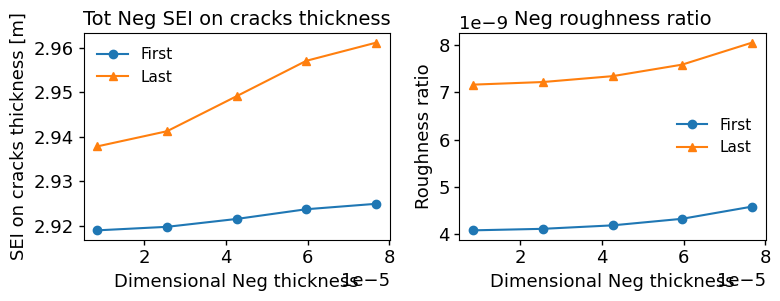

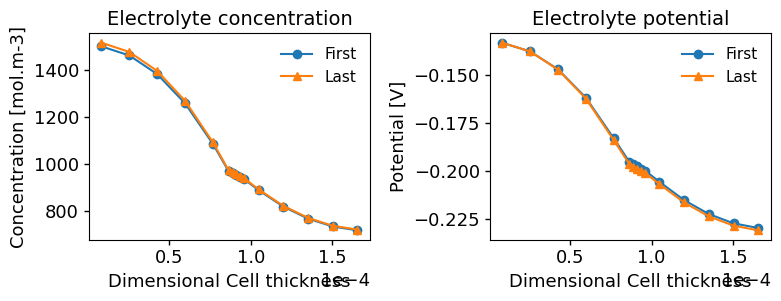

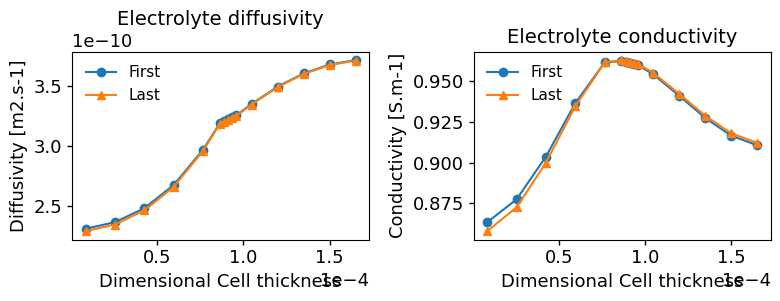

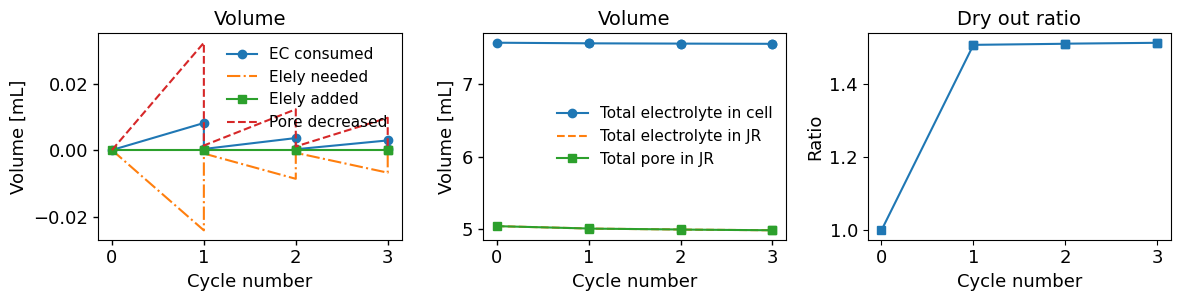

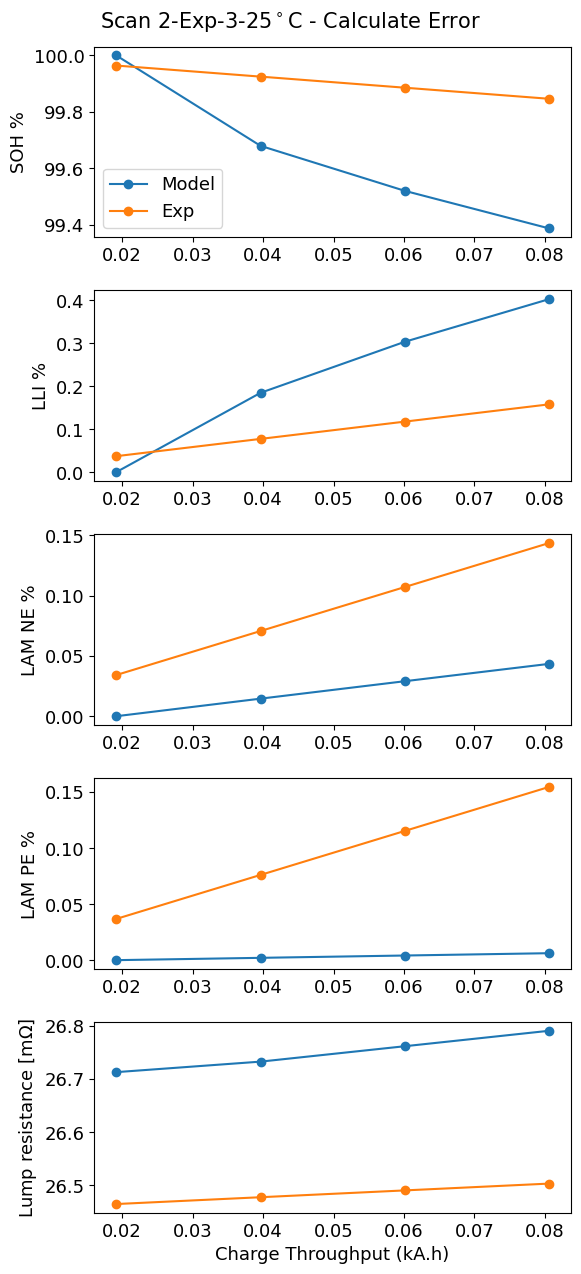

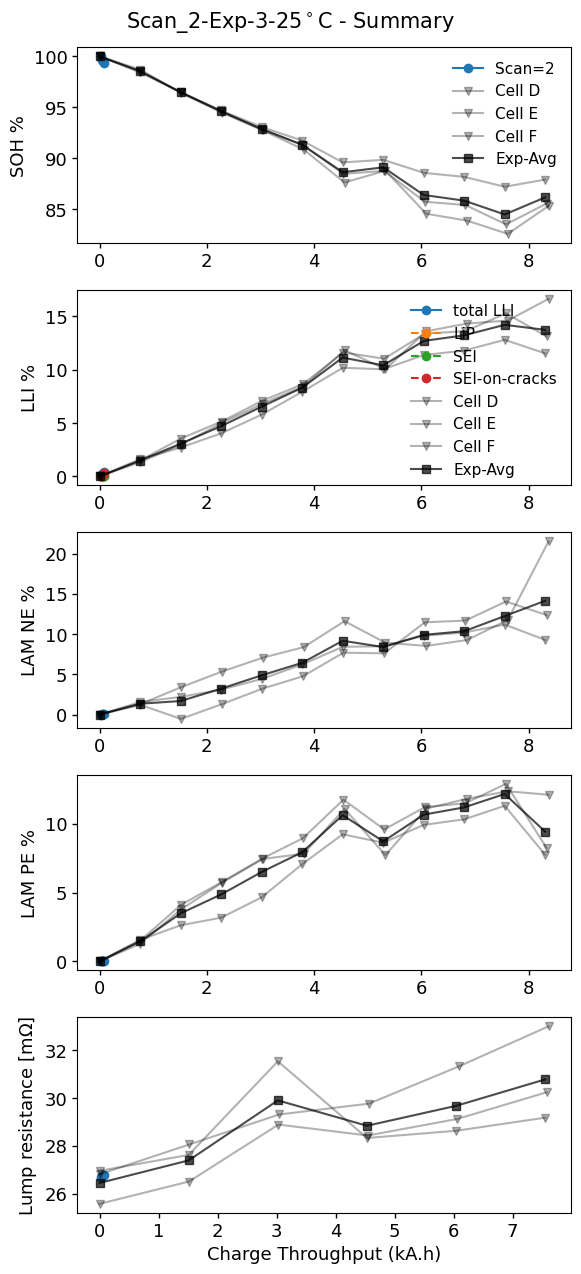

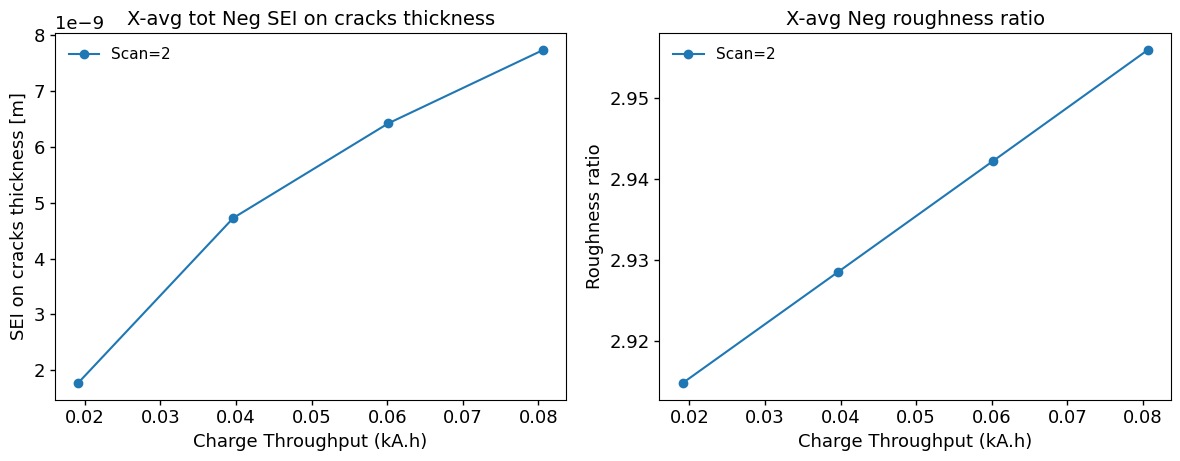

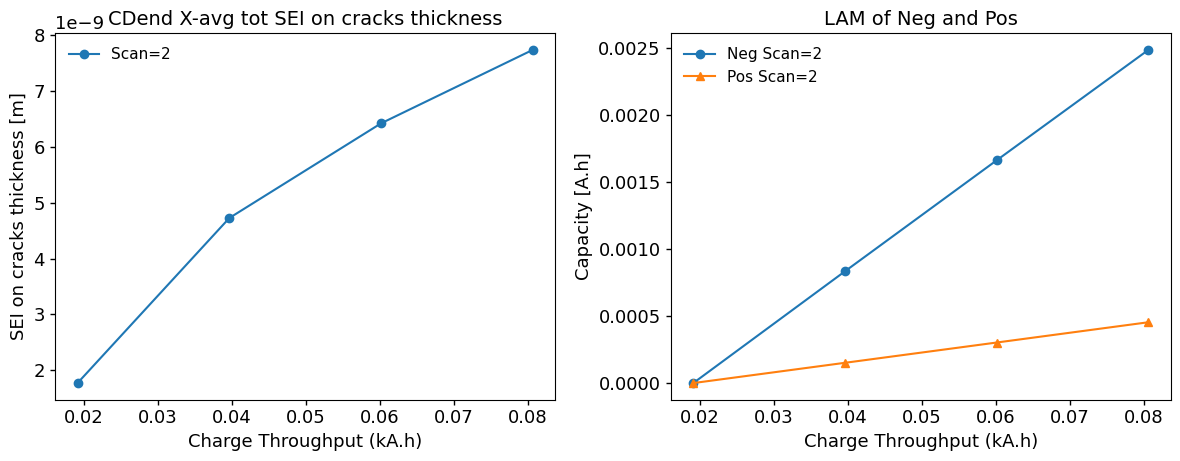

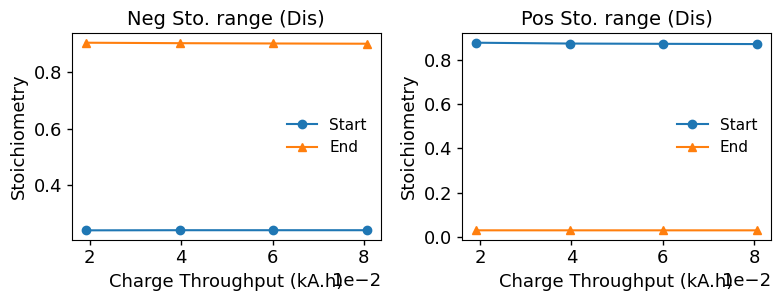

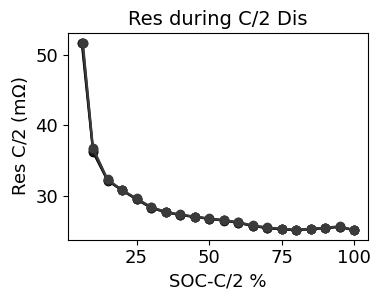

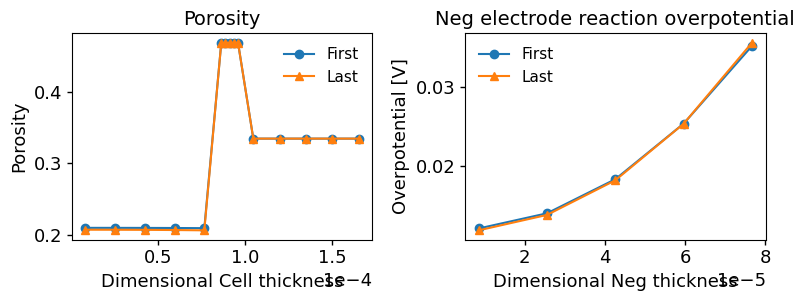

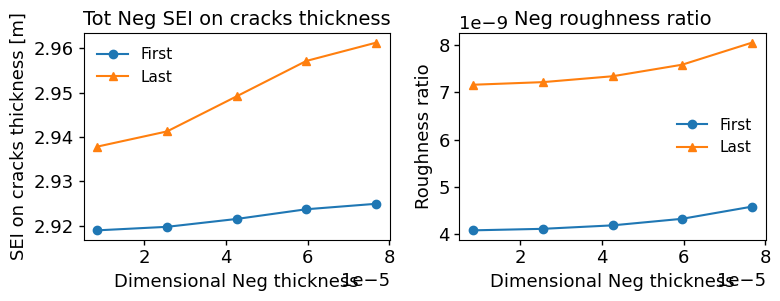

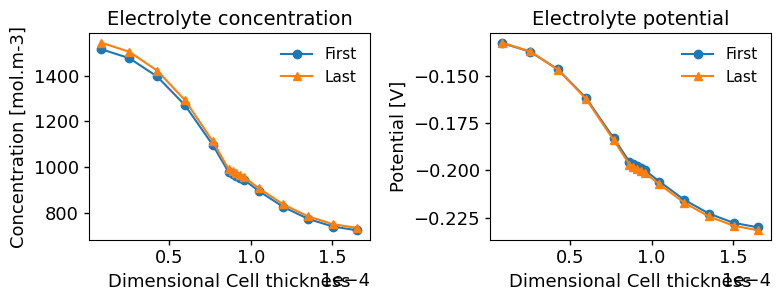

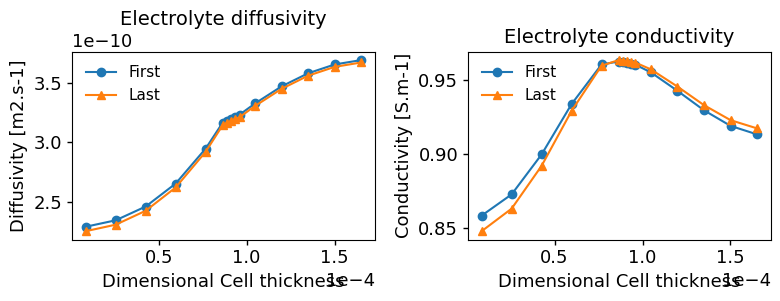

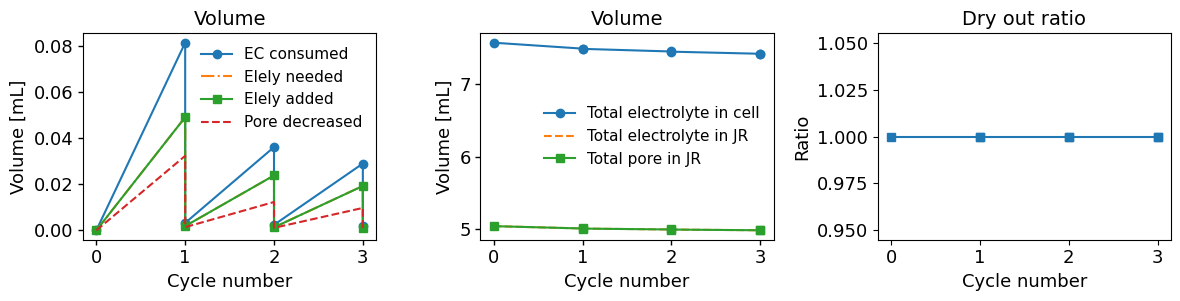

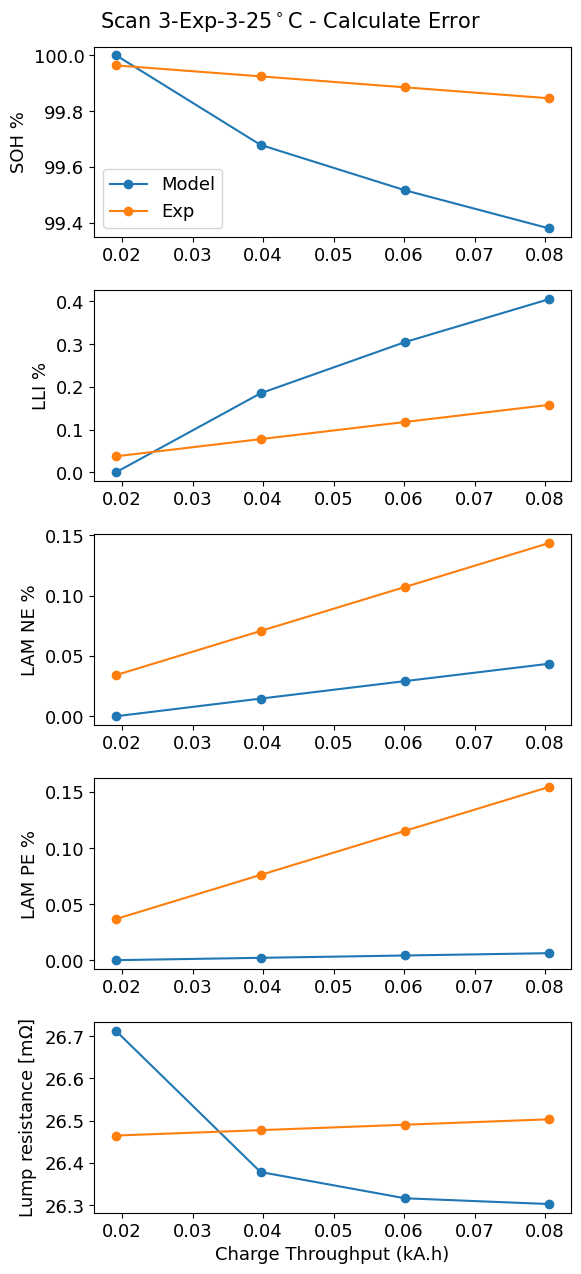

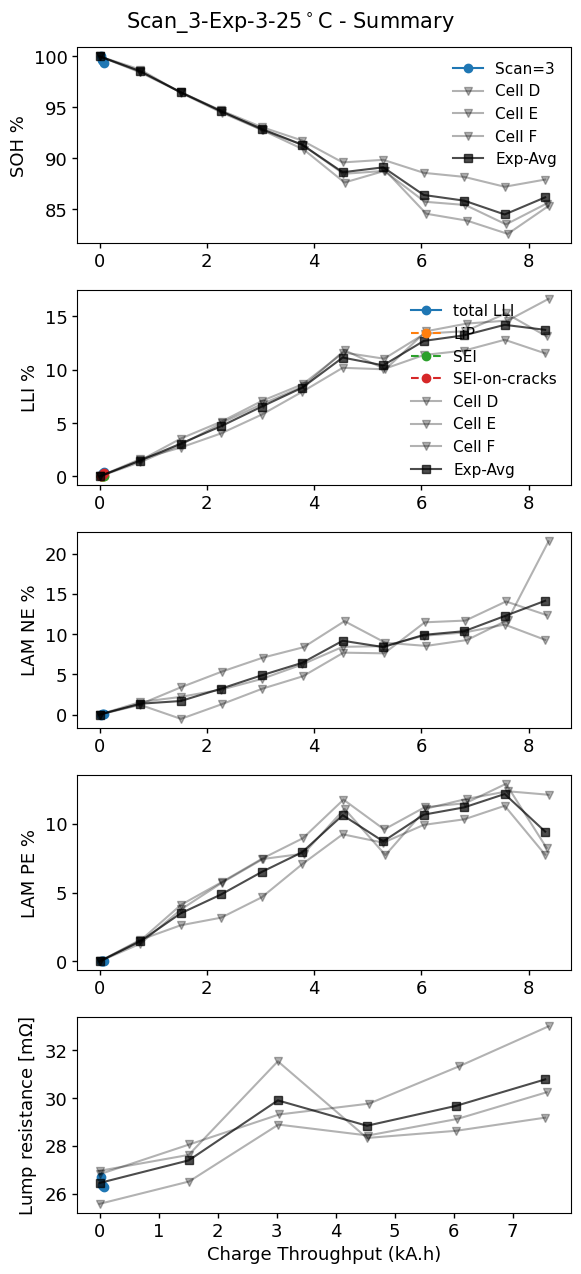

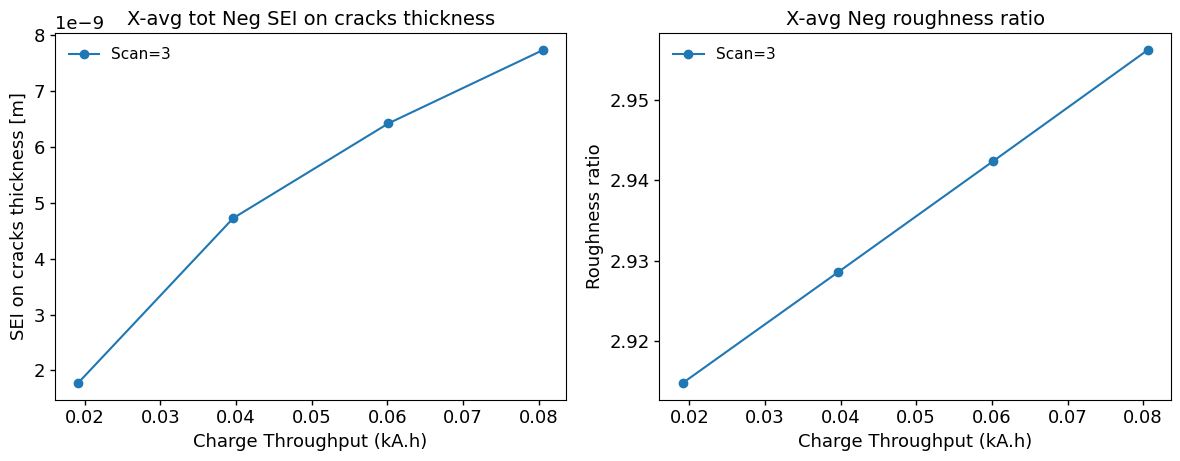

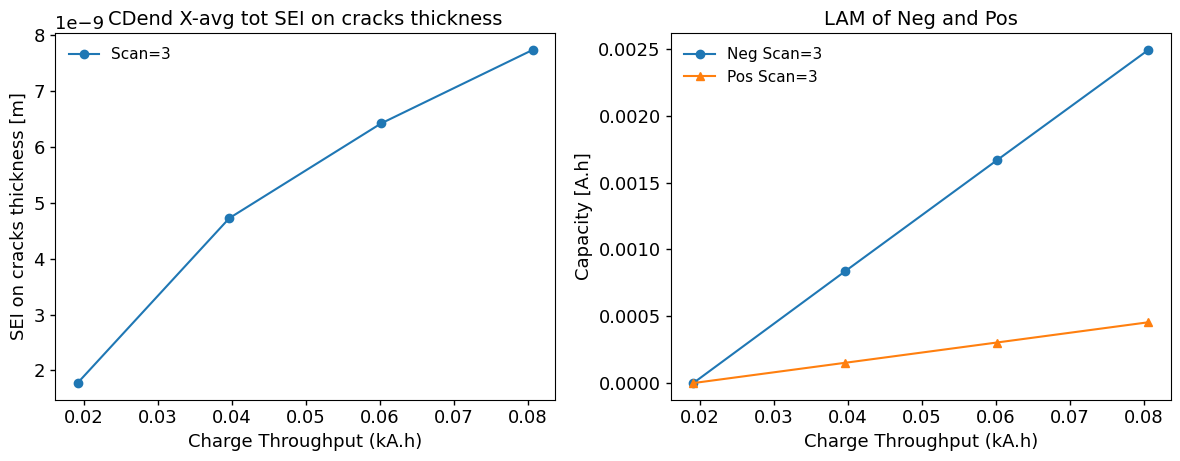

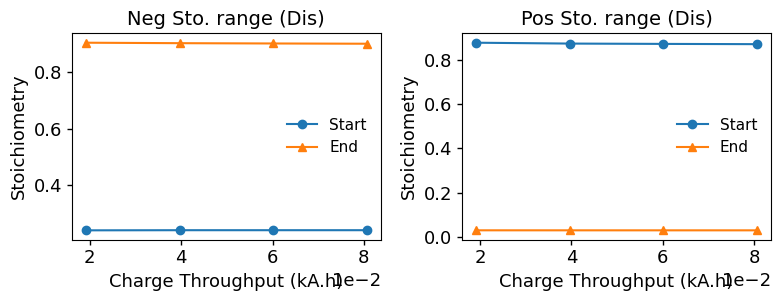

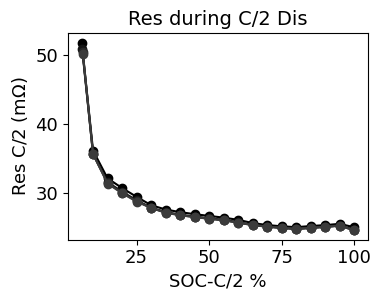

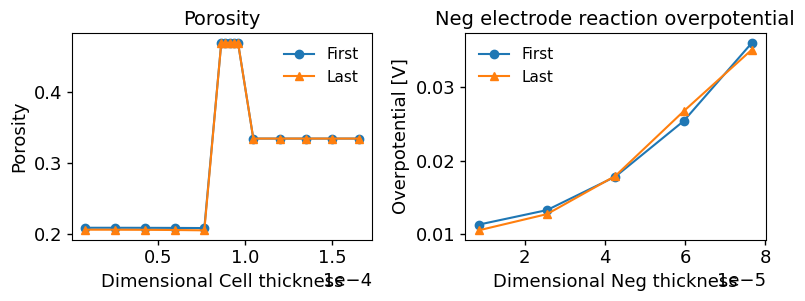

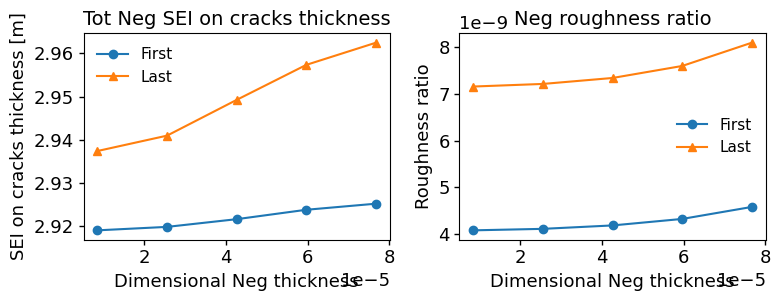

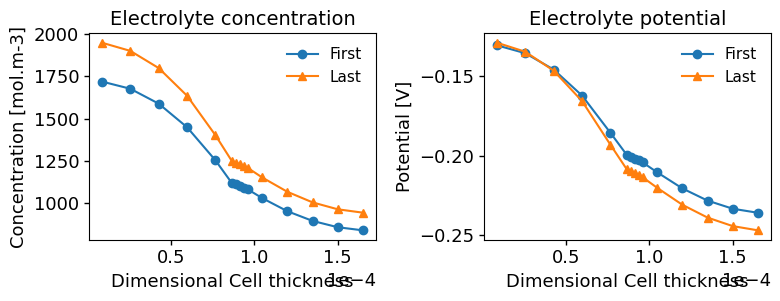

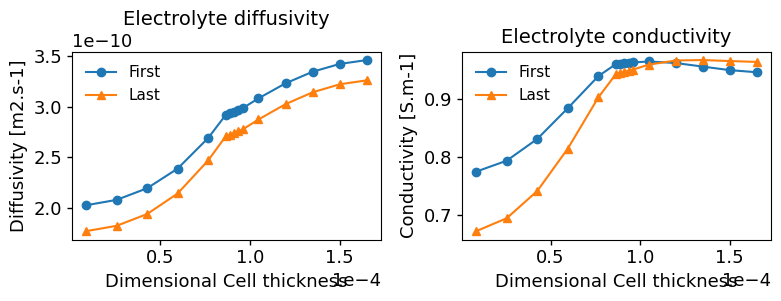

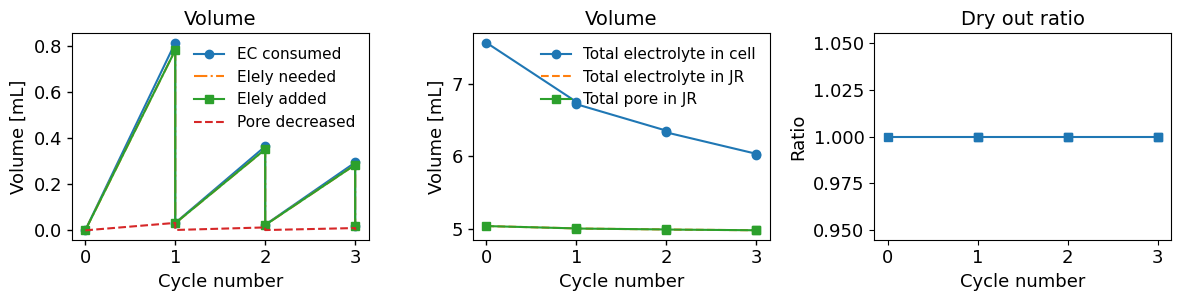

In [7]:
# scan:
fs = 13; dpi = 100;
index_list = np.arange(1,len(Para_dict_list)+1,1)
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp, dpi,
        Plot_Exp=True,Timeout=False,Return_Sol=True,Check_Small_Time=True,)  
    midc_merge_all.append(midc_merge)
    Sol_RPT_all.append(Sol_RPT)
    Sol_AGE_all.append(Sol_AGE)  

""" for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,    Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp,
        True,True,False,)    #Plot_Exp,  Timeout, Return_Sol  
"""
""" if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_P2_Opt_Timeout, 
        args=(
            index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
            keys_all,   exp_text_list, exp_index_pack,
            Exp_Any_AllData,Temp_Cell_Exp, dpi,
            True,False,True,True
        ) )
        for index_i, Para_dict_i in zip(index_list,Para_dict_list)]
    Result = [p.get() for p in processes]   """

""" for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2])  """


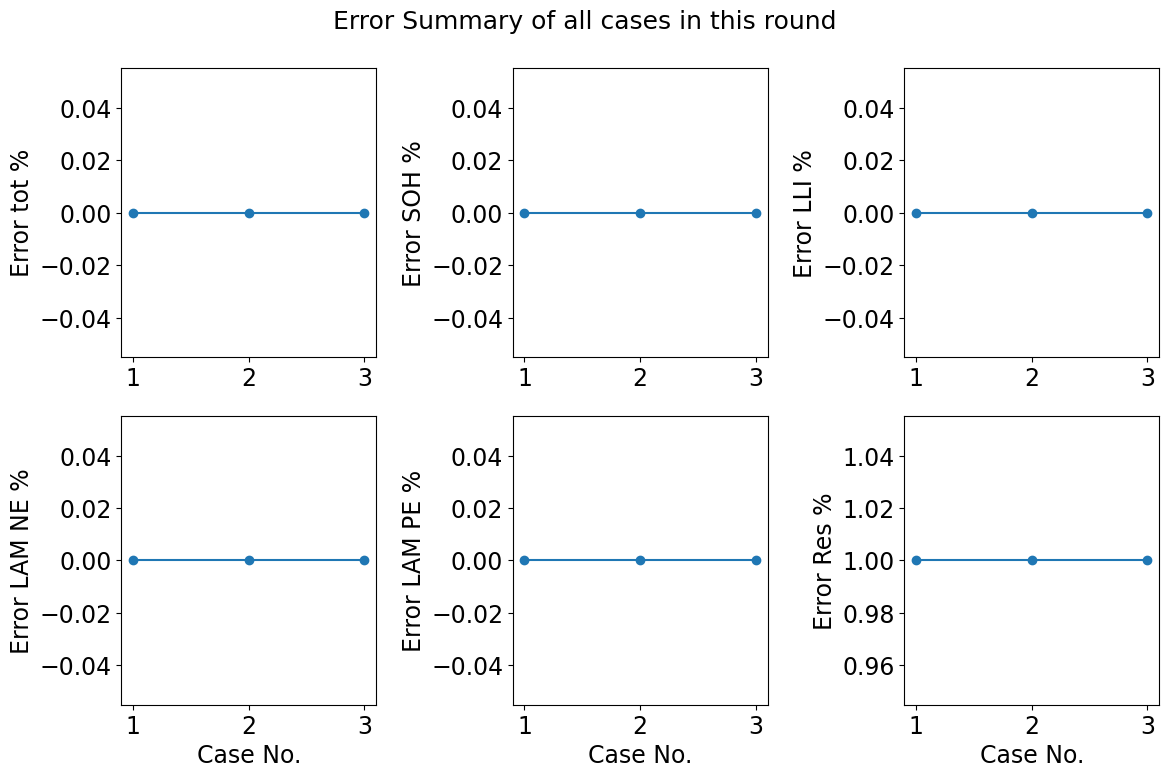

In [8]:
# After finish scans, get summary of the errors of all cases:
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Caes_Index = np.arange(1,len(midc_merge_all)+1)
Mpe_tot = []; Mpe_1 = [];Mpe_2 = []; Mpe_3 = [];Mpe_4 = []; Mpe_5 = [];
for i in range(len(midc_merge_all)):
    Mpe_tot.append(midc_merge_all[i]["Error tot %"])
    Mpe_1.append(midc_merge_all[i]["Error SOH %"])
    Mpe_2.append(midc_merge_all[i]["Error LLI %"])
    Mpe_3.append(midc_merge_all[i]["Error LAM NE %"])
    Mpe_4.append(midc_merge_all[i]["Error LAM PE %"])
    Mpe_5.append(midc_merge_all[i]["Error Res %"])
Mpe_All = [Mpe_tot,Mpe_1,Mpe_2,Mpe_3,Mpe_4,Mpe_5]
Str_All = [
    "Error tot %","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %"]
fig, axs = plt.subplots(2,3, figsize=(12,8),tight_layout=True)
for i in range(6):
    if i<=2: # 0,1,2
        m=0; n = i
    else:   # 3,4,5 
        m=1; n = i-3
    axs[m,n].plot( Caes_Index,  Mpe_All[i], '-o',  )
    axs[m,n].set_ylabel(Str_All[i])
    axs[1,n].set_xlabel("Case No.")
    fig.suptitle(
        f"Error Summary of all cases in this round", 
        fontsize=fs+1)
plt.savefig(
    BasicPath +  "/" + # Target+
    f"0!_-{index_exp} - Error Summary of all cases.png", dpi=600)
plt.savefig(
    BasicPath + "/" + # Target+
    f"0!_Exp-{index_exp} - Error Summary of all cases.svg")



In [9]:
Index_List_succeed = index_list
for index_i in Index_List_succeed:
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = index_i # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 


Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
Successfuly write results for Scan 3!
